In [1]:
# Import all the needed packages
import numpy as np
import matplotlib.pyplot as plt
import torch
import spyrit.core.torch as st

**Comparison of Three Methods in Distributed Sketching for Randomized Optimization**<br>
*Uniform Sampling*<br>
*Hadamard Randomized Sampling*<br>
*Subsampled Randomized Hadamard Transforom*<br>

**Step 1: Simulation**

In [2]:
def generate_heterogeneous_data(w2,mu_2,n, p, imbalance_factor=10, random_seed=39):
    np.random.seed(random_seed)
    
    # Parameters for two components
    # Component 1: Standard variance, centered at 0
    mu1 = np.zeros(p)
    sigma1 = np.eye(p)
    
    # Component 2: High variance, shifted mean and scaled covariance
    mu2 = np.ones(p) * mu_2  # Shifted mean
    sigma2 = np.eye(p) * imbalance_factor  # High variance component
    
    # Define mixing proportions (say, 80% from component 1 and 20% from component 2)
    weights = [1-w2, w2]
    
    # Generate data for each component
    n1 = int(n * weights[0])
    n2 = n - n1
    X1 = np.random.multivariate_normal(mu1, sigma1, size=n1)
    X2 = np.random.multivariate_normal(mu2, sigma2, size=n2)
    
    # Combine the data
    X = np.vstack((X1, X2))
    np.random.shuffle(X)
    epsilon = np.random.normal(0, 1, size=n)
    beta = np.random.normal(0, 1, size=p)
    Y = np.dot(X, beta) + epsilon
    return X, Y, beta

# Example usage
n = 8192       # number of rows         
p = 1000        # number of columns
w2 = 0.01      # weight of the second component
mu_2 = 5       # mean of the second component
imbalance_factor = 10 # imbalance factor for the second component
random_seed = 39 # random seed for reproducibility
X, Y, beta = generate_heterogeneous_data(w2, mu_2, n, p, imbalance_factor, random_seed)

**Step 2: Singular Value Decomposition (SVD)**<br>
*To show the sparsity and not even distribution*

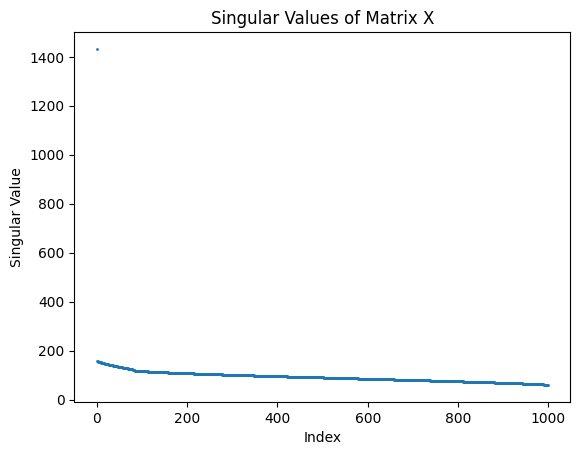

In [3]:
# Compute singular values
U, s, Vh = np.linalg.svd(X)

# Sort singular values in descending order
# s_sorted = np.sort(s)[::-1]

# Plot singular values using a dot plot
plt.scatter(range(len(s)), s,s = 1)
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.title('Singular Values of Matrix X')
plt.show()

**Step 3: Define functions for calculating error ratio and norms**

In [4]:
def calculate_the_norm_square(A, b, x_selected):
    A = np.array(A)
    x_selected = np.array(x_selected)
    return np.sum((np.dot(A, x_selected) - b) ** 2)
def error_ratio(A,b,x_hat_bar,x_star):
    return (calculate_the_norm_square(A,b,x_hat_bar) - calculate_the_norm_square(A,b,x_star)) / calculate_the_norm_square(A,b,x_star)

**Step 4: Solve for X_star**<br>

In [5]:
def solver(A,b):
    A = np.array(A)
    b = np.array(b)
    x_star = np.linalg.inv(A.T@A)@A.T@b
    return x_star
x_star = solver(X,Y)
norm_star = calculate_the_norm_square(X,Y,x_star)
print("The norm square of x_star calculated are:")
print(norm_star)

The norm square of x_star calculated are:
6957.1724016905155


**STEP 5: Uniform Sampling Sampling // Algorithm 1: Distributed Randomized Regression**

In [6]:
# e.g. our desired sketching size is m = 819 = [8192/10]
m = int(n/10)
# Algorithm 1 inserting inside uniform sampling: Distributed Randomized Regression

# S_k @ A here is just computed as A [uniformly_sampled_index]
# As S_k here is just a diagnoal matrix of 1 or 0 where sampled rows have 1 as value
def uniform_sampling_1(X,Y,n,m,q):
    X = np.array(X)
    Y = np.array(Y)
    x_hat_list = []
    for k in range(q):
        index = np.random.choice(n, size=m, replace=False)
        X_sk = X[index]
        Y_sk = Y[index]
        x_hat = np.linalg.inv(X_sk.T@X_sk)@X_sk.T@Y_sk
        x_hat_list.append(x_hat)
    x_bar = sum(x_hat_list) / q
    return x_bar

**Step 6: Hadamard Randomized Sampling // Algorithm 1: Distributed Randomized Regression**<br>

In [7]:
# Algorithm 1 inserting inside hadamard rademacher randomization: Distributed Randomized Regression

# Step 1: Hadamard rademacher randomization
from math import sqrt


def fhm(X,Y):
    # generate an diagonal matrix of -1 or 1 with 0.5 probability
    diag_matrix = np.diag(np.random.choice([-1, 1], size=X.shape[0]))
    signs = diag_matrix
    # multiply each row of X and Y by the corresponding sign
    result_X = np.dot(signs, X)
    result_Y = np.dot(signs, Y)
    # Convert to PyTorch tensor
    tensor_matrix_X = torch.tensor(result_X,dtype = torch.float32)
    tensor_matrix_Y = torch.tensor(result_Y,dtype = torch.float32)
    # Apply FWHT to the entire matrices
    tensor_matrix_X = st.fwht(tensor_matrix_X.T).T
    tensor_matrix_Y = st.fwht(tensor_matrix_Y)
    # Convert back to numpy array
    X = tensor_matrix_X.numpy()
    X = X/sqrt(X.shape[0])
    Y = tensor_matrix_Y.numpy()
    Y = Y/sqrt(Y.shape[0])
    return X,Y
X_hada,Y_hada = fhm(X,Y)

In [8]:
def Hadamard_Randomized_Sampling_1(X, Y, n, m, q):
    X = np.array(X)
    Y = np.array(Y)
    X, Y = fhm(X, Y)
    x_hat_list = []
    for k in range(q):
        index = np.random.choice(n, size=m, replace=False)
        X_sk = X[index]
        Y_sk = Y[index]
        x_hat = np.linalg.inv(X_sk.T @ X_sk) @ X_sk.T @ Y_sk
        x_hat_list.append(x_hat)
    x_bar = sum(x_hat_list) / q
    return x_bar

**Step 7: Subsampled Randomized Hadamard Transforom // Algorithm 1: Distributed Randomized Regression**<br>

In [9]:
def Subsampled_Randomized_Hadamard_Transform_1(X, Y, n, m, q):
    # Convert inputs to numpy arrays
    X = np.array(X)
    Y = np.array(Y)
    
    # Store copies of the original X and Y
    X_orig = X.copy()
    Y_orig = Y.copy()
    
    x_hat_list = []
    for k in range(q):
        # Apply fhm to the original X and Y, not the transformed versions
        X_transformed, Y_transformed = fhm(X_orig, Y_orig)
        
        # Subsample m rows from the transformed matrices
        index = np.random.choice(n, size=m, replace=False)
        X_sk = X_transformed[index]
        Y_sk = Y_transformed[index]
        
        # Ensure subsampled matrices are numpy arrays
        X_sk = np.array(X_sk)
        Y_sk = np.array(Y_sk)
        
        # Solve the smaller problem
        x_hat = solver(X_sk, Y_sk)
        x_hat_list.append(x_hat)
    
    # Average the solutions
    x_bar = sum(x_hat_list) / q
    return x_bar

**Step 8: Final Error Ratio plot for comparison of these three methods**<br>
*Note that in the Uniform Sampling there is two version: With padding or Without padding of matrices X and Y*<br>

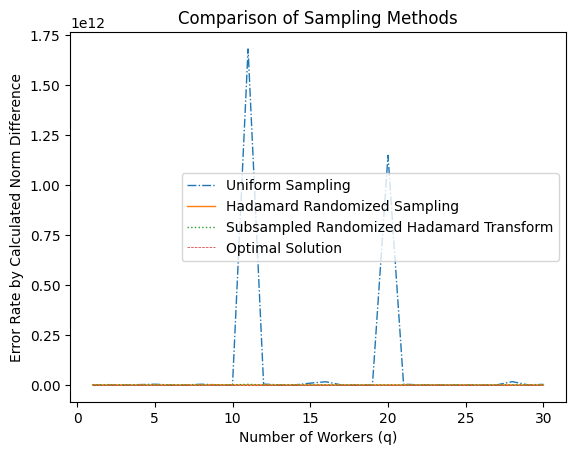

In [10]:
# Calculate the error rate for each method
error_uniform = []
error_hadamard = []
error_srht = []
error_star = np.zeros((30,1))

# Calculate the error rate for each method
for q in range(1, 31):  # adjust the range as needed
    x_bar_uniform = uniform_sampling_1(X, Y, n, m, q)
    x_bar_hadamard = Hadamard_Randomized_Sampling_1(X, Y, n, m, q)
    x_bar_srht = Subsampled_Randomized_Hadamard_Transform_1(X, Y, n, m, q)
    error_uniform_value = error_ratio(X, Y, x_bar_uniform, x_star)
    error_hadamard_value = error_ratio(X, Y, x_bar_hadamard, x_star)
    error_srht_value = error_ratio(X, Y, x_bar_srht, x_star)
    error_uniform.append(error_uniform_value)  # uniform sampling error
    error_hadamard.append(error_hadamard_value)
    error_srht.append(error_srht_value)  # Hadamard error
# Create the plot
plt.plot(range(1, 31), error_uniform, label='Uniform Sampling',linestyle = '-.',linewidth = 1)
plt.plot(range(1, 31), error_hadamard, label='Hadamard Randomized Sampling',linestyle = '-',linewidth = 1)
plt.plot(range(1, 31), error_srht, label='Subsampled Randomized Hadamard Transform',linestyle = ':',linewidth = 1)
plt.plot(range(1, 31), error_star, label='Optimal Solution', linestyle='--',linewidth = 0.5)

plt.xlabel('Number of Workers (q)')
plt.ylabel('Error Rate by Calculated Norm Difference')
plt.title('Comparison of Sampling Methods')
plt.legend()
plt.show()